In [6]:
import torch.nn as nn
import torch

In [7]:
record_number = 223
network_structure = [4, 8, 4]

num_epochs = 5
num_steps = 50
batch_size = 5

beta = 0.8

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

sampling_strategy = {1: 2044, 2: 800, 3: 500, 4: 100}

full_path = "Tanh[2,8,8,4]-batch-10.png"

## Importing Data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("kaggle.csv")
print(df["record"].unique())
df = df[df["record"] == record_number]

[101 106 108 109 112 114 115 116 118 119 122 124 201 203 205 207 208 209
 215 220 223 230 100 103 105 111 113 117 121 123 200 202 210 212 213 214
 219 221 222 228 231 232 233 234]


In [9]:
df = df[["record", "type", "0_qrs_interval", "0_pre-RR", "0_post-RR", "0_qt_interval", "0_st_interval"]]
df.dropna(inplace=True)

<Axes: >

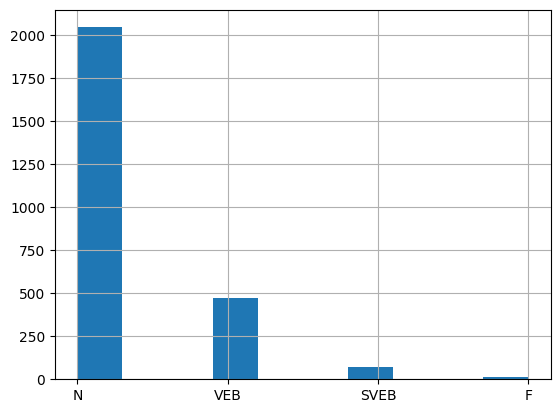

In [10]:
df["type"].hist()

In [11]:
df["type"] = df["type"].map({"N": 1, "SVEB": 2, "VEB": 3, "F": 4})

In [12]:
X = df[["0_pre-RR", "0_qrs_interval", "0_qt_interval", "0_st_interval"]]
y = df["type"]

In [13]:
from imblearn.over_sampling import SMOTE


sm = SMOTE(random_state=0, sampling_strategy=sampling_strategy)
X, y = sm.fit_resample(X=X, y=y)

In [14]:
X = (X - X.mean()) / X.std()
y = y.map(
    {1: [1, 0, 0, 0], 2: [0, 1, 0, 0], 3: [0, 0, 1, 0], 4: [0, 0, 0, 1]}
)
y = np.array(y.tolist())

## Splitting data for training and testing

In [15]:
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X.values).float()
y = torch.from_numpy(y).float()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=1
)

## Arythmia Classifier

In [16]:
import snntorch as snn

In [17]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(network_structure[0],network_structure[1])
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(network_structure[1], network_structure[2])
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):
        # Initialize hidden states at t=0

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # time-loop
        for _ in range(num_steps):
            cur1 = self.fc1(x)  
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            # store in list
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec).float(), torch.stack(
            mem2_rec, dim=0
        )  


# Load the network onto CUDA if available
net = Net().to(device)

## Training

In [18]:
import snntorch.functional as SF

In [19]:
loss_fn = SF.ce_count_loss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(beta,beta))

In [20]:
def train(model, optimizer, loss_fn, X_train, y_train, num_epochs, batch_size=5):

  # Calculate number of batches
  num_samples = len(X_train)
  num_batches = num_samples // batch_size

  for epoch in range(num_epochs):
    total_correct = 0
    for i in range(num_batches):
      # Get current batch of data
      start_idx = i
      end_idx = min(i + batch_size, num_samples)
      x_batch = X_train[start_idx:end_idx]
      y_batch = y_train[start_idx:end_idx]

      x_batch = x_batch.to(device)
      y_batch_idx = y_batch.max(1)[1]  
      y_batch_idx = y_batch_idx.to(device)

      # Forward pass
      spk2, _ = model(x_batch)
      
      # Calculate loss
      loss = loss_fn(spk2, y_batch_idx)

      accuracy = SF.acc.accuracy_rate(spk2, y_batch_idx)
      total_correct += accuracy.item() * len(y_batch) 

      # Backward pass and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    average_accuracy = total_correct / num_samples
    print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {average_accuracy:.4f}")

def evaluate(model, loss_fn, X_test, y_test, batch_size=5):

  # Initialize variables for tracking accuracy and loss
  total_correct = 0
  num_samples = len(y_test)
  total_loss = 0

  # Evaluate on test data in batches
  with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
      # Get current batch of data
      start_idx = i
      end_idx = min(i + batch_size, num_samples)
      x_batch = X_test[start_idx:end_idx]
      y_batch = y_test[start_idx:end_idx]

      x_batch = x_batch.to(device)
      y_batch_idx = y_batch.max(1)[1]  
      y_batch_idx = y_batch_idx.to(device)

      # Forward pass
      spk2, _ = model(x_batch)

      # Calculate accuracy
      accuracy = SF.acc.accuracy_rate(spk2, y_batch_idx)
      total_correct += accuracy.item() * len(y_batch)  

      # Calculate loss
      loss = loss_fn(spk2, y_batch_idx)  
      total_loss += loss.item() * len(y_batch) 

  # Calculate and print average accuracy and loss
  average_accuracy = total_correct / num_samples
  average_loss = total_loss / num_samples
  print(f"Test Accuracy: {average_accuracy:.4f}")
  print(f"Test Loss: {average_loss:.4f}")


In [21]:
train(net, optimizer, loss_fn, X_train, y_train, num_epochs=num_epochs, batch_size=batch_size)  

Epoch: 1/5, Loss: 0.6447, Accuracy: 0.6622
Epoch: 2/5, Loss: 0.0016, Accuracy: 0.7560
Epoch: 3/5, Loss: 0.0014, Accuracy: 0.8361
Epoch: 4/5, Loss: 0.0007, Accuracy: 0.8573
Epoch: 5/5, Loss: 0.0166, Accuracy: 0.8689


In [22]:
evaluate(net, loss_fn, X_test, y_test)

Test Accuracy: 0.8965
Test Loss: 0.4511
